<a href="https://colab.research.google.com/github/riyagpt0251/Bridge-stability-prediction/blob/main/Bridge_stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas scikit-learn matplotlib seaborn

#import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#load dataset

In [ ]:
df = pd.read_csv("Last_Year_All_Field_Bridges.csv")

# clean and prepare dataset

In [ ]:
df = pd.read_csv("Last_Year_All_Field_Bridges.csv")
print(df.columns.tolist())


['1 - State Code', '1 - State Name', '8 - Structure Number', '22 - Owner Agency', '3 - County Code', '3 - County Name', '4 - Place Code', 'City - InfoBridge Place Code', 'City - InfoBridge Place Name', '27 - Year Built', '29 - Average Daily Traffic', '43A - Main Span Material', '43B - Main Span Design', '45 - Number of Spans in Main Unit', '49 - Structure Length (ft.)', '6A - Features Intersected', '7 - Facility Carried By Structure', 'CAT10 - Bridge Condition', 'Bridge Age (yr)', 'CAT29 - Deck Area (sq. ft.)', '2 - Highway Agency District', '9 - Location', '11 - Mile Point (miles)', '16 - Latitude (decimal)', '17 - Longitude (decimal)', '21 - Maintenance Responsibility', '37 - Historical Significance Code', '98A - Neighboring State Name', '98B - Neighboring State Percent Responsibility', '99 - Border Bridge Structure Number', '101 - Parallel Structure Designation Code', '106 - Year Reconstructed', '44A - Approach Spans Material', '44B - Approach Spans Design', '46 - Number of Approach

<ipython-input-6-1695d4afcad5>:1: DtypeWarning: Columns (29,84,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Last_Year_All_Field_Bridges.csv")


In [ ]:
df.columns = df.columns.str.strip()

df = df[['27 - Year Built',
         '49 - Structure Length (ft.)',
         '52 - Deck Width - Out to Out (ft.)',
         '29 - Average Daily Traffic',
         '109 - Average Daily Truck Traffic (Percent ADT)']].dropna()

In [ ]:
df.columns = ['YearBuilt', 'LengthFt', 'DeckWidthFt', 'DailyTraffic', 'TruckTrafficPercent']

In [ ]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

# Compute estimated bending moment (simplified): M = wL²/8
# Assume: total weight w = daily traffic * truck factor * unit load (e.g., 0.75 tons)


In [ ]:

df['TotalLoad'] = df['DailyTraffic'] * (df['TruckTrafficPercent'] / 100) * 0.75  # simplified estimate
df['BendingMoment'] = (df['TotalLoad'] * df['LengthFt'] ** 2) / 8

# Approximate moment of resistance (assume linear with deck width)


In [ ]:
df['MomentOfResistance'] = df['DeckWidthFt'] * 10

# Estimate work life remaining


In [ ]:
df['BridgeAge'] = 2025 - df['YearBuilt']
df['EstimatedWorkLifeRemaining'] = 100 - df['BridgeAge']

# Estimate number of truss components based on span


In [ ]:
df['TrussComponents'] = (df['LengthFt'] // 10).astype(int)

# show some result

In [ ]:
print(df[['YearBuilt', 'LengthFt', 'DeckWidthFt', 'TotalLoad',
          'BendingMoment', 'MomentOfResistance',
          'EstimatedWorkLifeRemaining', ]].head())

   YearBuilt  LengthFt  DeckWidthFt  TotalLoad  BendingMoment  \
2       1990      63.0         16.1    15.9000   7.888388e+03   
3       1962     110.9         80.4   278.7000   4.284598e+05   
4       1975     120.1         27.6     3.6750   6.626030e+03   
5       1960    1433.1         34.4    61.6500   1.582691e+07   
6       2018    1294.9         30.5     2.9625   6.209274e+05   

   MomentOfResistance  EstimatedWorkLifeRemaining  
2               161.0                          65  
3               804.0                          37  
4               276.0                          50  
5               344.0                          35  
6               305.0                          93  


# plot bending moment vs deck width

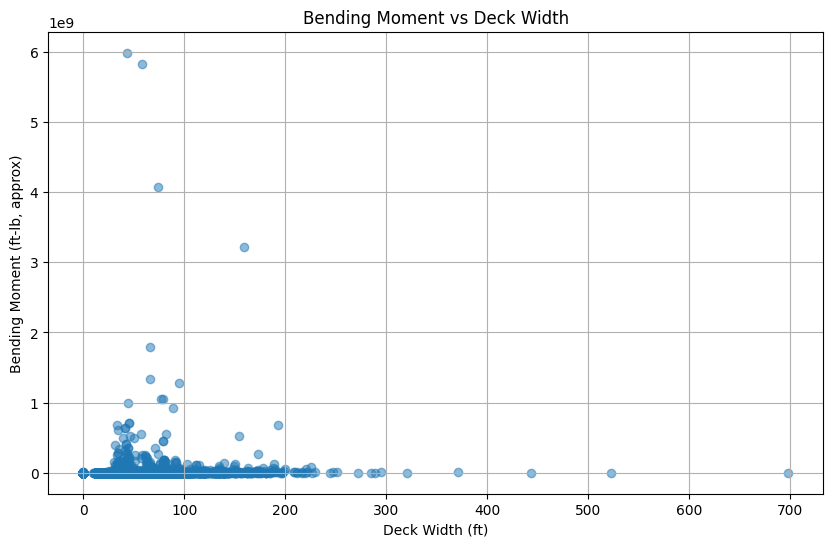

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['DeckWidthFt'], df['BendingMoment'], alpha=0.5)
plt.xlabel("Deck Width (ft)")
plt.ylabel("Bending Moment (ft-lb, approx)")
plt.title("Bending Moment vs Deck Width")
plt.grid(True)
plt.show()

# plot sfd and bmd

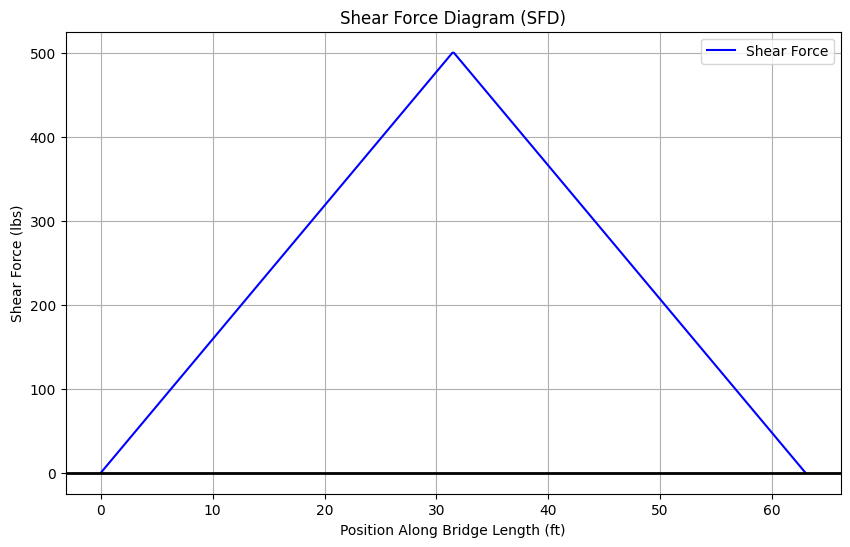

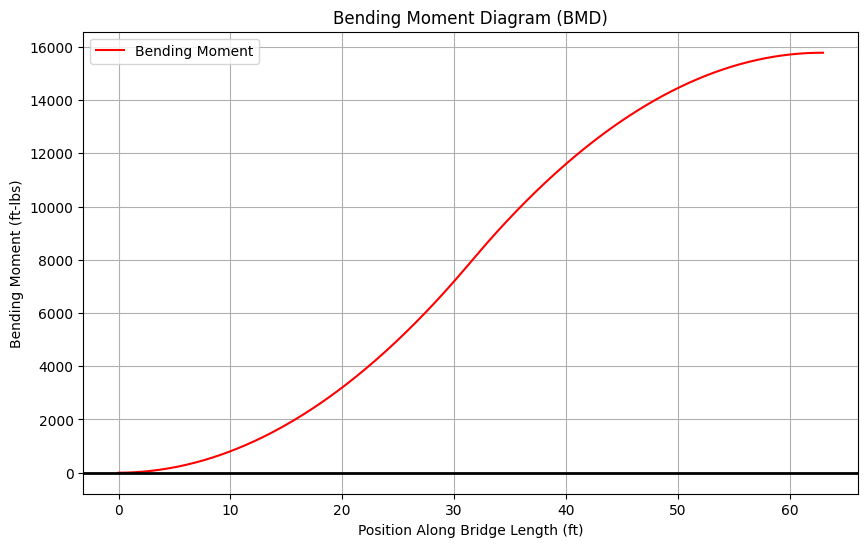

In [ ]:
def plot_sfd_bmd(length, load):
    # Simplified load distribution - concentrated load at the center of the span
    x = np.linspace(0, length, 500)

    # Shear force calculation (uniform load assumption)
    shear_force = load * (length / 2 - np.abs(x - length / 2))

    # Bending moment calculation
    bending_moment = np.cumsum(shear_force) * (x[1] - x[0])  # Approximate by summing shear force * dx

    # Plot Shear Force Diagram (SFD)
    plt.figure(figsize=(10,6))
    plt.plot(x, shear_force, label="Shear Force", color='b')
    plt.axhline(0, color='k', lw=2)
    plt.title("Shear Force Diagram (SFD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Shear Force (lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Bending Moment Diagram (BMD)
    plt.figure(figsize=(10,6))
    plt.plot(x, bending_moment, label="Bending Moment", color='r')
    plt.axhline(0, color='k', lw=2)
    plt.title("Bending Moment Diagram (BMD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Bending Moment (ft-lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage with data from the first bridge in the dataset
example_length = df['LengthFt'].iloc[0]  # First bridge length
example_load = df['TotalLoad'].iloc[0]  # First bridge load

plot_sfd_bmd(example_length, example_load)

# user input basis calculation

Enter the length of the bridge (in feet): 2000
Enter the deck width of the bridge (in feet): 400
Enter the average daily traffic (number of vehicles per day): 11000
Enter the percentage of truck traffic: 12
Bending Moment (approx): 495000000.00 ft-lb
Moment of Resistance (approx): 4000.00 ft-lb
Bridge is at risk of failure due to excessive bending moment.


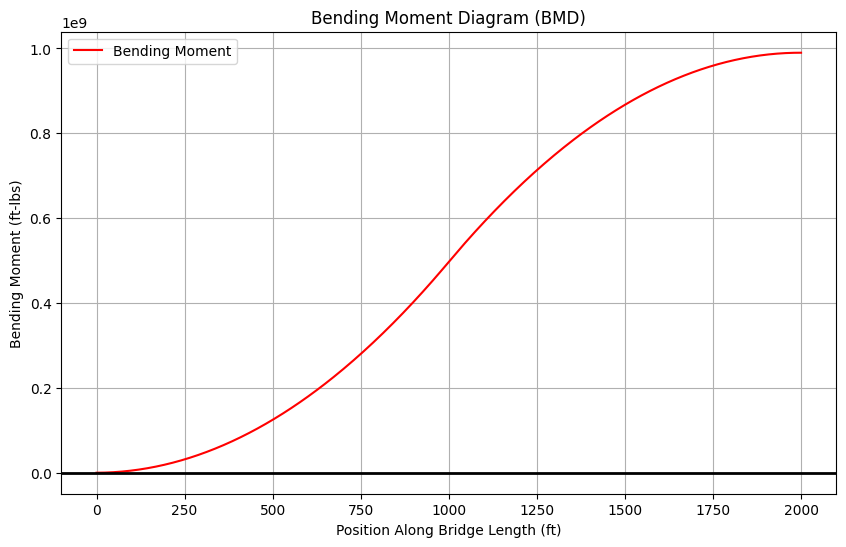

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Bending Moment
def calculate_bending_moment(length, daily_traffic, truck_traffic_percent, deck_width):
    # Assume: total weight w = daily traffic * truck factor * unit load (e.g., 0.75 tons)
    total_load = daily_traffic * (truck_traffic_percent / 100) * 0.75  # simplified estimate in tons
    bending_moment = (total_load * length ** 2) / 8  # Simple formula for bending moment (wL^2/8)

    # Moment of Resistance: Assumed linear with deck width and some material factor
    moment_of_resistance = deck_width * 10  # Simplified for demonstration

    return bending_moment, moment_of_resistance

# Function to predict bridge stability based on bending moment
def predict_stability(bending_moment, moment_of_resistance):
    if bending_moment > moment_of_resistance:
        return "Bridge is at risk of failure due to excessive bending moment."
    else:
        return "Bridge is stable under current load conditions."

# Function to take user input and predict bending moment and stability
def bridge_stability_analysis():
    # Taking user inputs for various characteristics of the bridge
    length = float(input("Enter the length of the bridge (in feet): "))
    deck_width = float(input("Enter the deck width of the bridge (in feet): "))
    daily_traffic = float(input("Enter the average daily traffic (number of vehicles per day): "))
    truck_traffic_percent = float(input("Enter the percentage of truck traffic: "))

    # Calculate bending moment and moment of resistance
    bending_moment, moment_of_resistance = calculate_bending_moment(length, daily_traffic, truck_traffic_percent, deck_width)

    # Predict stability based on bending moment
    stability_message = predict_stability(bending_moment, moment_of_resistance)

    # Output results
    print(f"Bending Moment (approx): {bending_moment:.2f} ft-lb")
    print(f"Moment of Resistance (approx): {moment_of_resistance:.2f} ft-lb")
    print(stability_message)

    # Plot the bending moment diagram
    x = np.linspace(0, length, 500)
    shear_force = (daily_traffic * (truck_traffic_percent / 100) * 0.75) * (length / 2 - np.abs(x - length / 2))
    bending_moment_curve = np.cumsum(shear_force) * (x[1] - x[0])  # Approximate by summing shear force * dx

    plt.figure(figsize=(10,6))
    plt.plot(x, bending_moment_curve, label="Bending Moment", color='r')
    plt.axhline(0, color='k', lw=2)
    plt.title("Bending Moment Diagram (BMD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Bending Moment (ft-lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the bridge stability analysis
bridge_stability_analysis()


In [ ]:
!apt-get install nodejs npm -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gyp javascript-common libc-ares2 libjs-events libjs-highlight.js
  libjs-inherits libjs-is-typedarray libjs-psl libjs-source-map
  libjs-sprintf-js libjs-typedarray-to-buffer libnode-dev libnode72
  libnotify-bin libnotify4 libuv1-dev node-abab node-abbrev node-agent-base
  node-ansi-regex node-ansi-styles node-ansistyles node-aproba node-archy
  node-are-we-there-yet node-argparse node-arrify node-asap node-asynckit
  node-balanced-match node-brace-expansion node-builtins node-cacache
  node-chalk node-chownr node-clean-yaml-object node-cli-table node-clone
  node-color-convert node-color-name node-colors node-columnify
  node-combined-stream node-commander node-console-control-strings
  node-copy-concurrently node-core-util-is node-coveralls node-cssom
  node-cssstyle node-debug node-decompress-response node-defaults
  node-delayed-st

In [ ]:
!node -v
!npm -v

v12.22.9
8.5.1


In [ ]:
!npm install -g @openapitools/openapi-generator-cli

npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@openapitools/openapi-generator-cli@2.19.1',
npm WARN EBADENGINE   required: { node: '>=16' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@nestjs/core@11.0.20',
npm WARN EBADENGINE   required: { node: '>= 20' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'fs-extra@11.3.0',
npm WARN EBADENGINE   required: { node: '>=14.14' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'glob@9.3.5',
npm WARN EBADENGINE   required: { node: '>=16 || 14 >=14.17' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine 

In [ ]:
!npm fund

content



In [ ]:
!npx @openapitools/openapi-generator-cli version-manager set 7.12.0


Need to install the following packages:
  @openapitools/openapi-generator-cli
Ok to proceed? (y) y
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@openapitools/openapi-generator-cli@2.19.1',
npm WARN EBADENGINE   required: { node: '>=16' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@nestjs/core@11.0.20',
npm WARN EBADENGINE   required: { node: '>= 20' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'fs-extra@11.3.0',
npm WARN EBADENGINE   required: { node: '>=14.14' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'glob@9.3.5',
npm WARN EBADENGINE   required: { node: '>=16 || 14 >=14.17' },
npm WARN EBADENGINE   curren

In [ ]:
!npm install @openapitools/openapi-generator-cli -D

npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@openapitools/openapi-generator-cli@2.19.1',
npm WARN EBADENGINE   required: { node: '>=16' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@nestjs/core@11.0.20',
npm WARN EBADENGINE   required: { node: '>= 20' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'fs-extra@11.3.0',
npm WARN EBADENGINE   required: { node: '>=14.14' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'glob@9.3.5',
npm WARN EBADENGINE   required: { node: '>=16 || 14 >=14.17' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine 

In [ ]:
!wget https://raw.githubusercontent.com/OAI/OpenAPI-Specification/main/examples/v3.0/petstore.yaml -O openapi.yaml

--2025-04-22 13:10:08--  https://raw.githubusercontent.com/OAI/OpenAPI-Specification/main/examples/v3.0/petstore.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-22 13:10:08 ERROR 404: Not Found.



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving openapi.yaml to openapi (1).yaml


In [ ]:
!openapi-generator-cli generate \
    -i openapi.yaml \
    -g python \
    -o ./generated-python-sdk


/usr/local/lib/node_modules/@openapitools/openapi-generator-cli/main.js:2
(()=>{"use strict";var e=[,e=>{e.exports=require("@nestjs/core")},(e,t,a)=>{var o,r,n;Object.defineProperty(t,"__esModule",{value:!0}),t.AppModule=void 0;const i=a(3),s=a(4),p=a(5),l=a(6),c=a(7),g=a(8),d=a(9),v=a(11),h=process.env.HTTP_PROXY||process.env.http_proxy,m=process.env.HTTPS_PROXY||process.env.https_proxy,u={},f=new c.ProxyAgent;h&&(u.proxy=!1,u.httpAgent=f),m&&(u.proxy=!1,u.httpsAgent=f);let b=class AppModule{constructor(e,t,a){this.program=e,this.versionManager=t,this.passThroughService=a,this.onApplicationBootstrap=async()=>{let e=this.versionManager.getSelectedVersion();if(!e){const[{version:t}]=await this.versionManager.search(["latest"]).toPromise();await this.versionManager.setSelectedVersion(t),e=t}await this.versionManager.downloadIfNeeded(e),await this.passThroughService.init(),this.program.parse(process.argv)}}};t.AppModule=b,t.AppModule=b=i.__decorate([(0,s.Module)({imports:[p.HttpModule.reg

In [ ]:
!npm uninstall -g @openapitools/openapi-generator-cli
!npm install -g @openapitools/openapi-generator-cli


removed 163 packages, and audited 1 package in 3s

found 0 vulnerabilities
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@openapitools/openapi-generator-cli@2.19.1',
npm WARN EBADENGINE   required: { node: '>=16' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: '@nestjs/core@11.0.20',
npm WARN EBADENGINE   required: { node: '>= 20' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'fs-extra@11.3.0',
npm WARN EBADENGINE   required: { node: '>=14.14' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', npm: '8.5.1' }
npm WARN EBADENGINE }
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'glob@9.3.5',
npm WARN EBADENGINE   required: { node: '>=16 || 14 >=14.17' },
npm WARN EBADENGINE   current: { node: 'v12.22.9', 

In [ ]:
# Download the jar
!wget https://repo1.maven.org/maven2/org/openapitools/openapi-generator-cli/6.2.1/openapi-generator-cli-6.2.1.jar -O openapi-generator-cli.jar

# Run generation
!java -jar openapi-generator-cli.jar generate \
    -i openapi.yaml \
    -g python \
    -o ./generated-python-sdk

--2025-04-22 13:17:59--  https://repo1.maven.org/maven2/org/openapitools/openapi-generator-cli/6.2.1/openapi-generator-cli-6.2.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26022872 (25M) [application/java-archive]
Saving to: ‘openapi-generator-cli.jar’

openapi-generator-c 100%[===================>]  24.82M  --.-KB/s    in 0.1s    

2025-04-22 13:17:59 (170 MB/s) - ‘openapi-generator-cli.jar’ saved [26022872/26022872]

Exception in thread "main" java.lang.NullPointerException
	at org.openapitools.codegen.DefaultCodegen.setOpenAPI(DefaultCodegen.java:832)
	at org.openapitools.codegen.ClientOptInput.setOpenAPI(ClientOptInput.java:111)
	at org.openapitools.codegen.ClientOptInput.openAPI(ClientOptInput.java:35)
	at org.openapitools.codegen.config.CodegenConfigurator.toClientOptInput(Codegen

In [ ]:
!openapi-generator-cli generate \
    -i openapi.yaml \
    -g python \
    -o ./generated-python-sdk


/usr/local/lib/node_modules/@openapitools/openapi-generator-cli/main.js:2
(()=>{"use strict";var e=[,e=>{e.exports=require("@nestjs/core")},(e,t,a)=>{var o,r,n;Object.defineProperty(t,"__esModule",{value:!0}),t.AppModule=void 0;const i=a(3),s=a(4),p=a(5),l=a(6),c=a(7),g=a(8),d=a(9),v=a(11),h=process.env.HTTP_PROXY||process.env.http_proxy,m=process.env.HTTPS_PROXY||process.env.https_proxy,u={},f=new c.ProxyAgent;h&&(u.proxy=!1,u.httpAgent=f),m&&(u.proxy=!1,u.httpsAgent=f);let b=class AppModule{constructor(e,t,a){this.program=e,this.versionManager=t,this.passThroughService=a,this.onApplicationBootstrap=async()=>{let e=this.versionManager.getSelectedVersion();if(!e){const[{version:t}]=await this.versionManager.search(["latest"]).toPromise();await this.versionManager.setSelectedVersion(t),e=t}await this.versionManager.downloadIfNeeded(e),await this.passThroughService.init(),this.program.parse(process.argv)}}};t.AppModule=b,t.AppModule=b=i.__decorate([(0,s.Module)({imports:[p.HttpModule.reg

In [ ]:
!ls ./generated-python-sdk


ls: cannot access './generated-python-sdk': No such file or directory


In [ ]:
!openapi-generator-cli version


/usr/local/lib/node_modules/@openapitools/openapi-generator-cli/main.js:2
(()=>{"use strict";var e=[,e=>{e.exports=require("@nestjs/core")},(e,t,a)=>{var o,r,n;Object.defineProperty(t,"__esModule",{value:!0}),t.AppModule=void 0;const i=a(3),s=a(4),p=a(5),l=a(6),c=a(7),g=a(8),d=a(9),v=a(11),h=process.env.HTTP_PROXY||process.env.http_proxy,m=process.env.HTTPS_PROXY||process.env.https_proxy,u={},f=new c.ProxyAgent;h&&(u.proxy=!1,u.httpAgent=f),m&&(u.proxy=!1,u.httpsAgent=f);let b=class AppModule{constructor(e,t,a){this.program=e,this.versionManager=t,this.passThroughService=a,this.onApplicationBootstrap=async()=>{let e=this.versionManager.getSelectedVersion();if(!e){const[{version:t}]=await this.versionManager.search(["latest"]).toPromise();await this.versionManager.setSelectedVersion(t),e=t}await this.versionManager.downloadIfNeeded(e),await this.passThroughService.init(),this.program.parse(process.argv)}}};t.AppModule=b,t.AppModule=b=i.__decorate([(0,s.Module)({imports:[p.HttpModule.reg

In [ ]:
!wget https://petstore3.swagger.io/api/v3/openapi.yaml -O petstore.yaml


--2025-04-22 13:20:51--  https://petstore3.swagger.io/api/v3/openapi.yaml
Resolving petstore3.swagger.io (petstore3.swagger.io)... 34.239.74.99, 52.201.49.41
Connecting to petstore3.swagger.io (petstore3.swagger.io)|34.239.74.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/yaml]
Saving to: ‘petstore.yaml’

petstore.yaml           [ <=>                ]  21.58K  --.-KB/s    in 0s      

2025-04-22 13:20:51 (217 MB/s) - ‘petstore.yaml’ saved [22093]



In [ ]:
!openapi-generator-cli generate \
    -i petstore.yaml \
    -g python \
    -o ./generated-python-sdk


/usr/local/lib/node_modules/@openapitools/openapi-generator-cli/main.js:2
(()=>{"use strict";var e=[,e=>{e.exports=require("@nestjs/core")},(e,t,a)=>{var o,r,n;Object.defineProperty(t,"__esModule",{value:!0}),t.AppModule=void 0;const i=a(3),s=a(4),p=a(5),l=a(6),c=a(7),g=a(8),d=a(9),v=a(11),h=process.env.HTTP_PROXY||process.env.http_proxy,m=process.env.HTTPS_PROXY||process.env.https_proxy,u={},f=new c.ProxyAgent;h&&(u.proxy=!1,u.httpAgent=f),m&&(u.proxy=!1,u.httpsAgent=f);let b=class AppModule{constructor(e,t,a){this.program=e,this.versionManager=t,this.passThroughService=a,this.onApplicationBootstrap=async()=>{let e=this.versionManager.getSelectedVersion();if(!e){const[{version:t}]=await this.versionManager.search(["latest"]).toPromise();await this.versionManager.setSelectedVersion(t),e=t}await this.versionManager.downloadIfNeeded(e),await this.passThroughService.init(),this.program.parse(process.argv)}}};t.AppModule=b,t.AppModule=b=i.__decorate([(0,s.Module)({imports:[p.HttpModule.reg

In [90]:
from google.colab import files
import zipfile
import os

# Step 1: Upload the SDK zip file
uploaded = files.upload()

# Step 2: Extract if 'python-sdk.zip' was uploaded
if 'python-sdk.zip' in uploaded:
    # Create the directory if it doesn't exist
    if not os.path.exists("python-sdk"):
        os.mkdir("python-sdk")

    # Unzip the SDK
    with zipfile.ZipFile("python-sdk.zip", 'r') as zip_ref:
        zip_ref.extractall("python-sdk")

    print("✅ SDK extracted to 'python-sdk/' folder.")
else:
    print("❌ 'python-sdk.zip' not found in uploaded files.")


Saving python-sdk.zip to python-sdk.zip
✅ SDK extracted to 'python-sdk/' folder.


In [92]:
import sys
sys.path.append('/content/python-sdk')


In [94]:
import os
print(os.listdir("python-sdk"))


['generated-python-sdk']
